## City of Chicago Crime Data - Exploratory Data Analysis

### Import Packages

In [1]:
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

### Read in Data

In [2]:
crimes = pd.read_csv('../data/All Crimes Categorized.csv', parse_dates = [1])

In [3]:
crimes.head()

,ID,Date,Community Area,Type,Year,Month,Day of Week,Hour
0,10224738,2015-09-05 13:30:00,New City,Violent,2015,9,Saturday,13
1,10224739,2015-09-04 11:30:00,Austin,Property,2015,9,Friday,11
2,11646166,2018-09-01 00:01:00,Chatham,Property,2018,9,Saturday,0
3,10224740,2015-09-05 12:45:00,Avondale,Drugs,2015,9,Saturday,12
4,10224741,2015-09-05 13:00:00,Austin,Violent,2015,9,Saturday,13


### Crimes by Hour, Day of Week, Month of Year

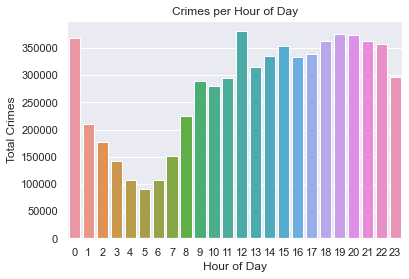

In [4]:
crimes_by_hour = pd.DataFrame(crimes['Hour'].value_counts().sort_index()).reset_index()
crimes_by_hour.columns=['Hour of Day','Total Crimes']
sns.barplot(data=crimes_by_hour, x='Hour of Day',y='Total Crimes')
plt.title('Crimes per Hour of Day');

Here you can see clearly that crimes are at their lowest early in the morning and peak in the evening and nighttime hours.

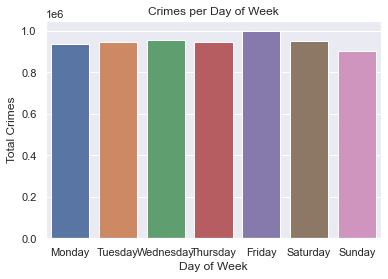

In [5]:
crimes_by_dayofweek = pd.DataFrame(crimes['Day of Week'].value_counts().sort_index()).reset_index()
crimes_by_dayofweek.columns=['Day of Week','Total Crimes']
daysOfWeek = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
cat_type = CategoricalDtype(categories=daysOfWeek, ordered=True)
crimes_by_dayofweek['Day of Week'] = crimes_by_dayofweek['Day of Week'].astype(cat_type)
sns.barplot(data=crimes_by_dayofweek, x='Day of Week',y='Total Crimes')
plt.title('Crimes per Day of Week');

We can see that crimes are highest on Friday and lowest on Sunday but there isn't really that much difference.  

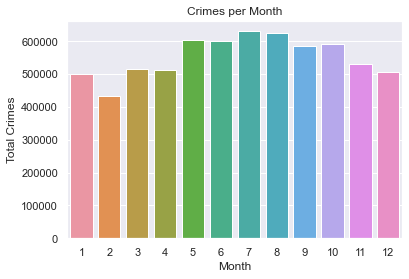

In [6]:
crimes_by_month = pd.DataFrame(crimes['Month'].value_counts().sort_index()).reset_index()
crimes_by_month.columns=['Month','Total Crimes']
sns.barplot(data=crimes_by_month, x='Month',y='Total Crimes')
plt.title('Crimes per Month');

Crimes are higher in the summer months than in the winter, and lowest in February (which makes sense since it has fewer days).   

### Group Data - by crime type and day

#### First group by day and primary type

In [7]:
crimes.set_index('Date', inplace=True)

In [8]:
crimes_byday = crimes[['ID','Type']].groupby(by=[crimes.index.date,'Type']).count().rename(columns={'ID':'Count'})

In [9]:
crimes_byday = crimes_byday.reset_index().rename(columns={'level_0':'Date'}).set_index('Date')

In [10]:
crimes_byday.head()

,Type,Count
Date,,
2002-05-01,Drugs,148
2002-05-01,Other,176
2002-05-01,Property,690
2002-05-01,Public Order / Vice,42
2002-05-01,Violent,390


In [11]:
# Now pivot the table
crimes_byday = crimes_byday.pivot(columns='Type',values='Count')

In [12]:
crimes_byday.head()

Type,Drugs,Other,Property,Public Order / Vice,Violent,White Collar
Date,,,,,,
2002-05-01,148,176,690,42,390,50
2002-05-02,166,97,585,51,340,30
2002-05-03,142,67,627,46,382,50
2002-05-04,168,65,607,33,410,30
2002-05-05,94,62,637,25,439,24


#### Add total crimes column

In [13]:
crimes_byday['Total Crimes'] = crimes_byday.sum(axis=1)

In [14]:
crimes_byday['Total Crimes'].sum()

6628734

#### Convert index back to datetime and set frequency

In [15]:
crimes_byday.index = pd.to_datetime(crimes_byday.index)

In [16]:
crimes_byday.index.freq = 'd'

In [17]:
crimes_byday.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6836 entries, 2002-05-01 to 2021-01-16
Freq: D
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Drugs                6836 non-null   int64
 1   Other                6836 non-null   int64
 2   Property             6836 non-null   int64
 3   Public Order / Vice  6836 non-null   int64
 4   Violent              6836 non-null   int64
 5   White Collar         6836 non-null   int64
 6   Total Crimes         6836 non-null   int64
dtypes: int64(7)
memory usage: 427.2 KB


### Data Visualization - All Crimes

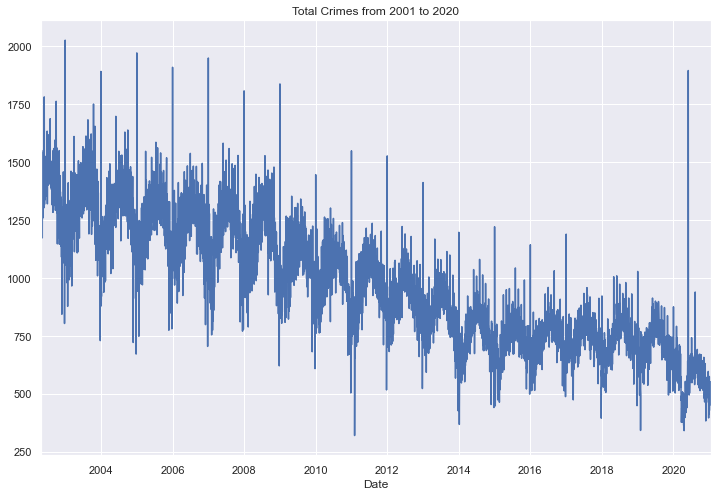

In [18]:
crimes_byday['Total Crimes'].plot(figsize=(12,8))
plt.title('Total Crimes from 2001 to 2020');

We can see from the plot that there is strong annual seasonality as well as a downward trend.  The trend does not appear to be exponential (although it's not quite linear either) and so we'll try both an additive model and multiplicative model for our smoothing algorithm.  In addition there seem to be large spikes on a yearly basis.  We also see a spike this past year, presumably during the time of the riots in the summer.  Let's try to to decompose this and see what we've got. 

### Seasonal Decomposition

In [19]:
decomp = seasonal_decompose(crimes_byday['Total Crimes'], period=365, model = 'add')

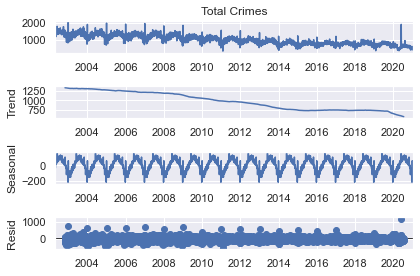

In [20]:
decomp.plot();

We can see the strong annual seasonal component. Let's try multiplicative.  

In [21]:
decomp = seasonal_decompose(crimes_byday['Total Crimes'], period=365, model = 'mul')

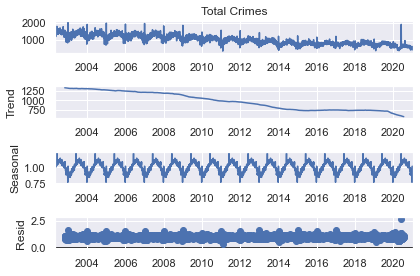

In [22]:
decomp.plot();

Interesting.  The multiplicative model tends to capture the yearly spikes as part of the seasonal component, whereas the additive model didn't, and had a much larger residual.  For this reason, it probably makes sense to use a multiplicative model, although we can try both.   

I also imagine there is a weekly component as well, so let's just look at the last three months.  

In [23]:
decomp = seasonal_decompose(crimes_byday['Total Crimes'].loc['2020-10-01':], period=7, model = 'add')

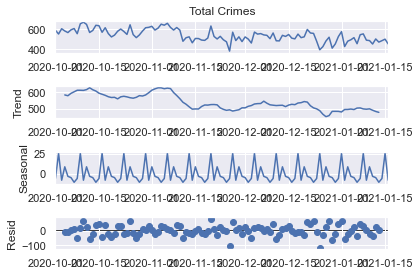

In [24]:
decomp.plot();

So we can see that there is a weekly seasonal component, but it isn't as strong as I would have imagined.  

Let's investigate these spikes a bit further.  We'll blow up just the first five years.  

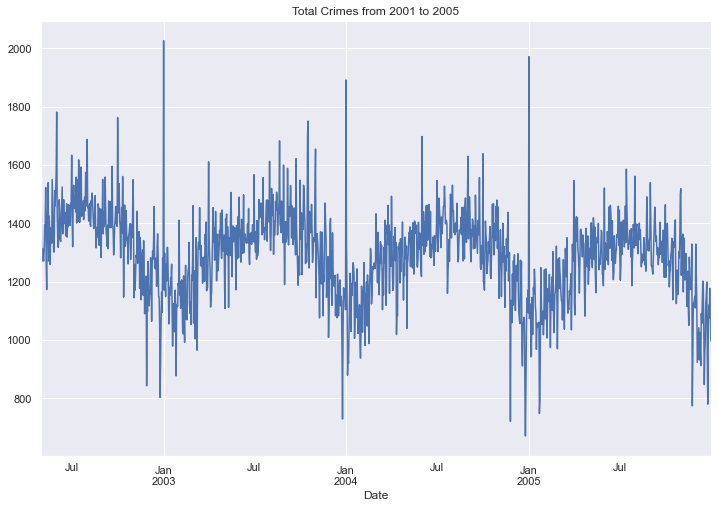

In [25]:
crimes_byday['Total Crimes'].loc['2001-01-01':'2005-12-31'].plot(figsize=(12,8))
plt.title('Total Crimes from 2001 to 2005');

So we see clearly that crimes are generaly higher in the summer and lower in the winter.  There also appears to be a sharp decrease right around the holidays followed by a short spike right on New Year's Day. Let's investigate this further.  

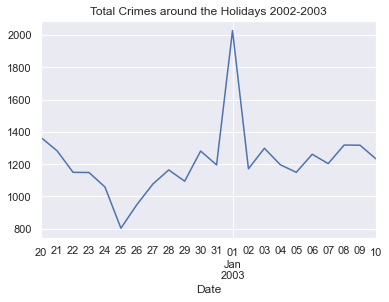

In [26]:
crimes_byday['Total Crimes'].loc['2002-12-20':'2003-01-10'].plot(figsize=(6,4))
plt.title('Total Crimes around the Holidays 2002-2003');

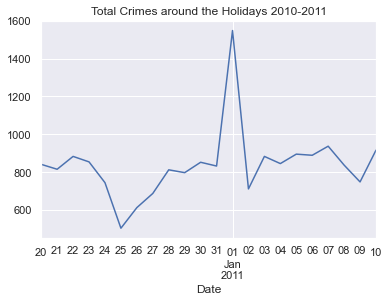

In [27]:
crimes_byday['Total Crimes'].loc['2010-12-20':'2011-01-10'].plot(figsize=(6,4))
plt.title('Total Crimes around the Holidays 2010-2011');

So we're definitely seeing a pattern here.  Crimes are very low on Christmas Day, then gradually increase and then there's a big spike on New Year's Day (presumably in the early morning hours).  Interesting!  

Let's also look at the big spike last summer.  

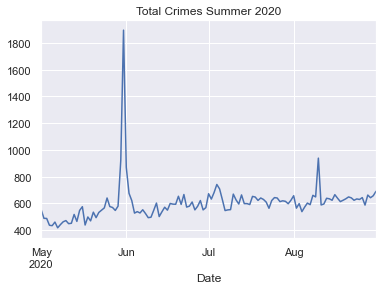

In [28]:
crimes_byday['Total Crimes'].loc['2020-05-01':'2020-08-31'].plot(figsize=(6,4))
plt.title('Total Crimes Summer 2020');

I've researched the dates of the looting in Chicago.  June 1st as well as August 9th and 10th were very violent days, so this corresponds to what we're seeing. 

### Plot ACF and PACF

Let's plot the ACF and PACF for one year's worth of data.  

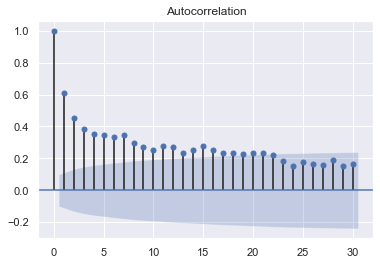

In [29]:
plot_acf(crimes_byday['Total Crimes'].loc['2020-01-01':], lags=30);

Notice the strong positive autocorrelation or momentum shown by crime data.  

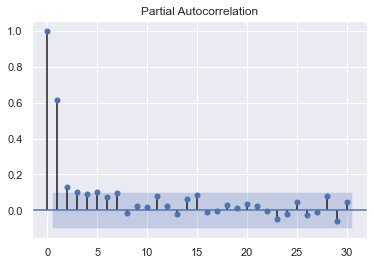

In [30]:
plot_pacf(crimes_byday['Total Crimes'].loc['2020-01-01':], lags=30);

Looking at the above two graphs, we see that the PACF graph drops off quickly after 1 lag, and the ACF decreases gradually.  This suggests that we can model the time series with a strictly AR(1) process.  

In [31]:
diff_total_crimes = crimes_byday['Total Crimes'].diff(periods=1)
diff_total_crimes.dropna(inplace=True)

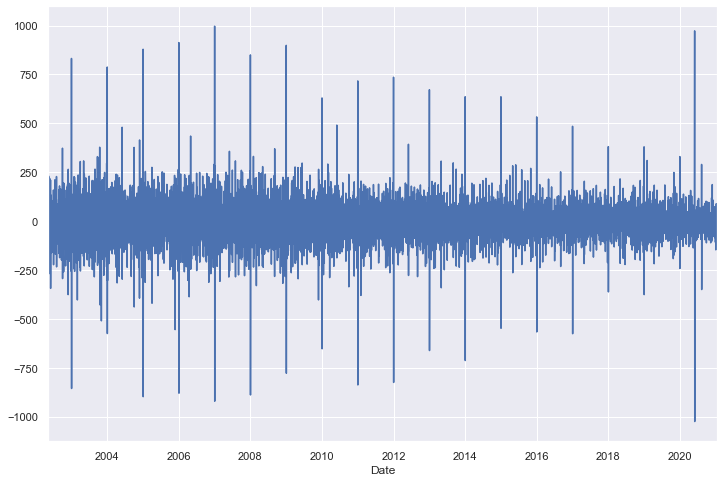

In [32]:
diff_total_crimes.plot(figsize=(12,8));

This still doesn't look quite stationary becuase it seems the variance is decreasing over time.  Let's check with ADFuller test.

In [33]:
adfuller(diff_total_crimes)

(-16.288147894615246,
 3.359274210927349e-29,
 35,
 6799,
 {'1%': -3.431312166584914,
  '5%': -2.8619651983534067,
  '10%': -2.566996329335048},
 79695.59872031886)

The ADFuller test shows a very small p-value, so we can reject the null hypothesis and conclude that our differenced time series is now stationary.  Let's plot the ACF and PACF again.  

### Data Visualization - Crime Categories

Now let's plot categories of crimes, which will consist of everything except "Total Crimes", "Arrest", and "Domestic" (since those all contain the other categories).  

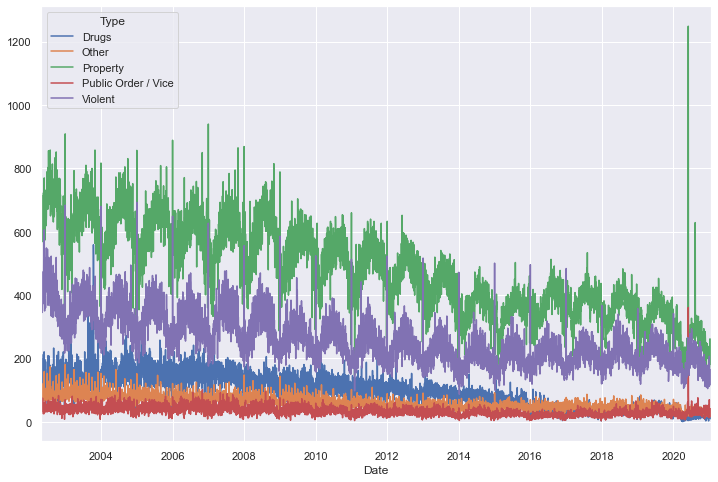

In [34]:
crime_groups = crimes_byday.columns[:5]

crimes_byday[crime_groups].plot(figsize=(12,8),legend=True);

Let's zoom in on 2020.

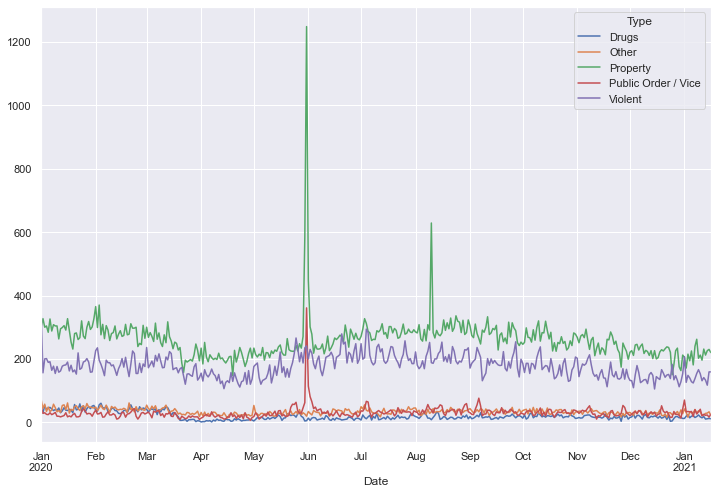

In [35]:
crimes_byday[crime_groups].loc['2020-01-01':].plot(figsize=(12,8),legend=True);

### Group Crimes by Community Area

In [36]:
crimes.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6628734 entries, 2015-09-05 13:30:00 to 2021-01-16 11:26:00
Data columns (total 7 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   ID              int64 
 1   Community Area  object
 2   Type            object
 3   Year            int64 
 4   Month           int64 
 5   Day of Week     object
 6   Hour            int64 
dtypes: int64(4), object(3)
memory usage: 404.6+ MB


In [37]:
crimes_byarea = crimes[['ID','Community Area']].groupby(by=[crimes.index.date,'Community Area']).count().rename(columns={'ID':'Count'})

In [38]:
crimes_byarea = crimes_byarea.reset_index().rename(columns={'level_0':'Date'}).set_index('Date')

In [39]:
crimes_byarea.head()

,Community Area,Count
Date,,
2002-05-01,Albany Park,17
2002-05-01,Archer Heights,2
2002-05-01,Armour Square,7
2002-05-01,Ashburn,22
2002-05-01,Auburn Gresham,50


In [40]:
# Now pivot the table
crimes_byarea = crimes_byarea.pivot(columns='Community Area',values='Count')

In [42]:
crimes_byarea.fillna(0, inplace=True)
community_areas_list = list(crimes_byarea.columns)
for community_area in community_areas_list:
    crimes_byarea[community_area] = crimes_byarea[community_area].astype(int)

In [43]:
crimes_byarea.head()

Community Area,Albany Park,Archer Heights,Armour Square,Ashburn,Auburn Gresham,Austin,Avalon Park,Avondale,Belmont Cragin,Beverly Hills,...,Washington Heights,Washington Park,West Elsdon,West Englewood,West Garfield Park,West Lawn,West Pullman,West Ridge,West Town,Woodlawn
Date,,,,,,,,,,,,,,,,,,,,,
2002-05-01,17,2,7,22,50,91,8,10,28,4,...,18,9,6,44,25,16,25,11,46,19
2002-05-02,14,3,4,10,42,72,6,13,27,4,...,11,11,6,40,23,7,20,8,39,26
2002-05-03,11,5,8,12,39,71,6,15,22,3,...,13,14,5,44,15,14,14,21,33,18
2002-05-04,12,3,7,8,31,71,4,16,30,9,...,13,8,11,78,20,6,21,17,51,27
2002-05-05,13,2,7,8,30,77,3,8,27,4,...,5,12,5,39,20,11,21,14,45,18


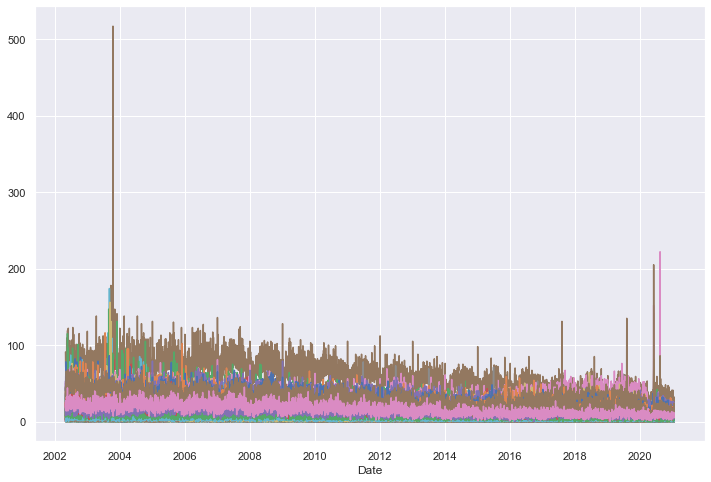

In [44]:
crimes_byarea.plot(figsize=(12,8),legend=False);

This is not easy to visualize.  We've got 77 community areas, each with its own time series of crimes.  We see some really large spikes, and we can see that there is a wide range in terms of amount of crimes.  So what we want to do now is attempt to cluster these time series.

Let's look at a few community areas, and see how they differ.  

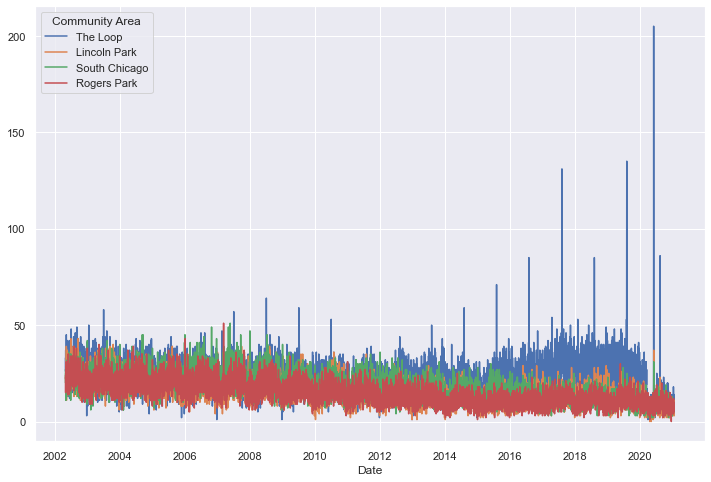

In [45]:
crimes_byarea[['The Loop','Lincoln Park','South Chicago','Rogers Park']].plot(figsize=(12,8),legend=True);

This is just too noisy to look at.  Let's apply a rolling mean to this data.  

In [46]:
crimes_byarea_7DayAvg = crimes_byarea.rolling(7).mean()

In [47]:
crimes_byarea_7DayAvg.dropna(inplace=True)

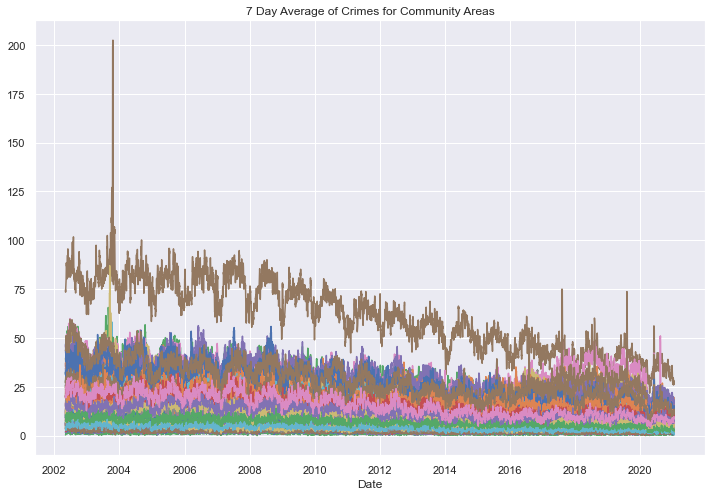

In [48]:
crimes_byarea_7DayAvg.plot(figsize=(12,8),legend=False)
plt.title('7 Day Average of Crimes for Community Areas');

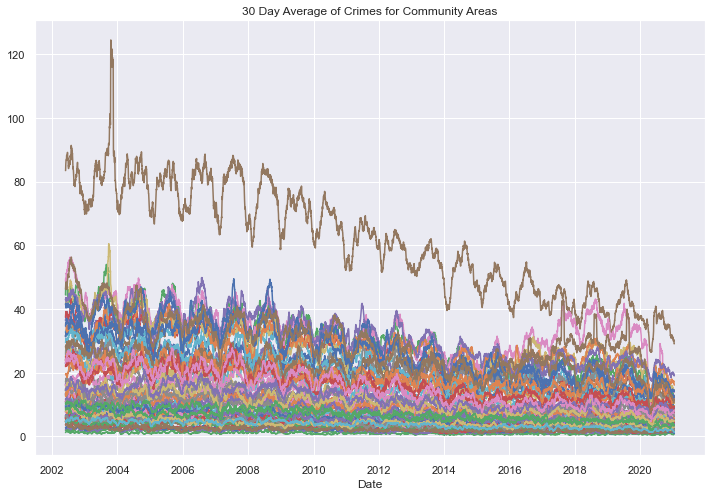

In [49]:
crimes_byarea_30DayAvg = crimes_byarea.rolling(30).mean()

crimes_byarea_30DayAvg.dropna(inplace=True)

crimes_byarea_30DayAvg.plot(figsize=(12,8),legend=False)
plt.title('30 Day Average of Crimes for Community Areas');

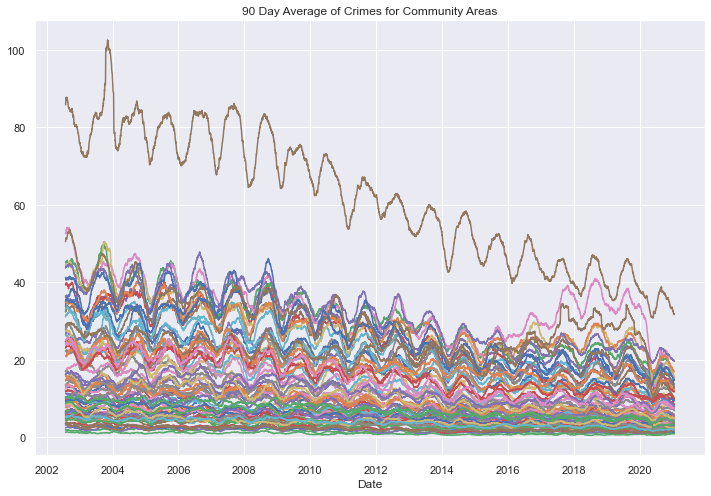

In [53]:
crimes_byarea_90DayAvg = crimes_byarea.rolling(90).mean()

crimes_byarea_90DayAvg.dropna(inplace=True)

crimes_byarea_90DayAvg.plot(figsize=(12,8),legend=False)
plt.title('90 Day Average of Crimes for Community Areas');

It's easier now to see trends as the noise is smoothed out.  Let's see if we see some different patterns that might make clustering useful.   

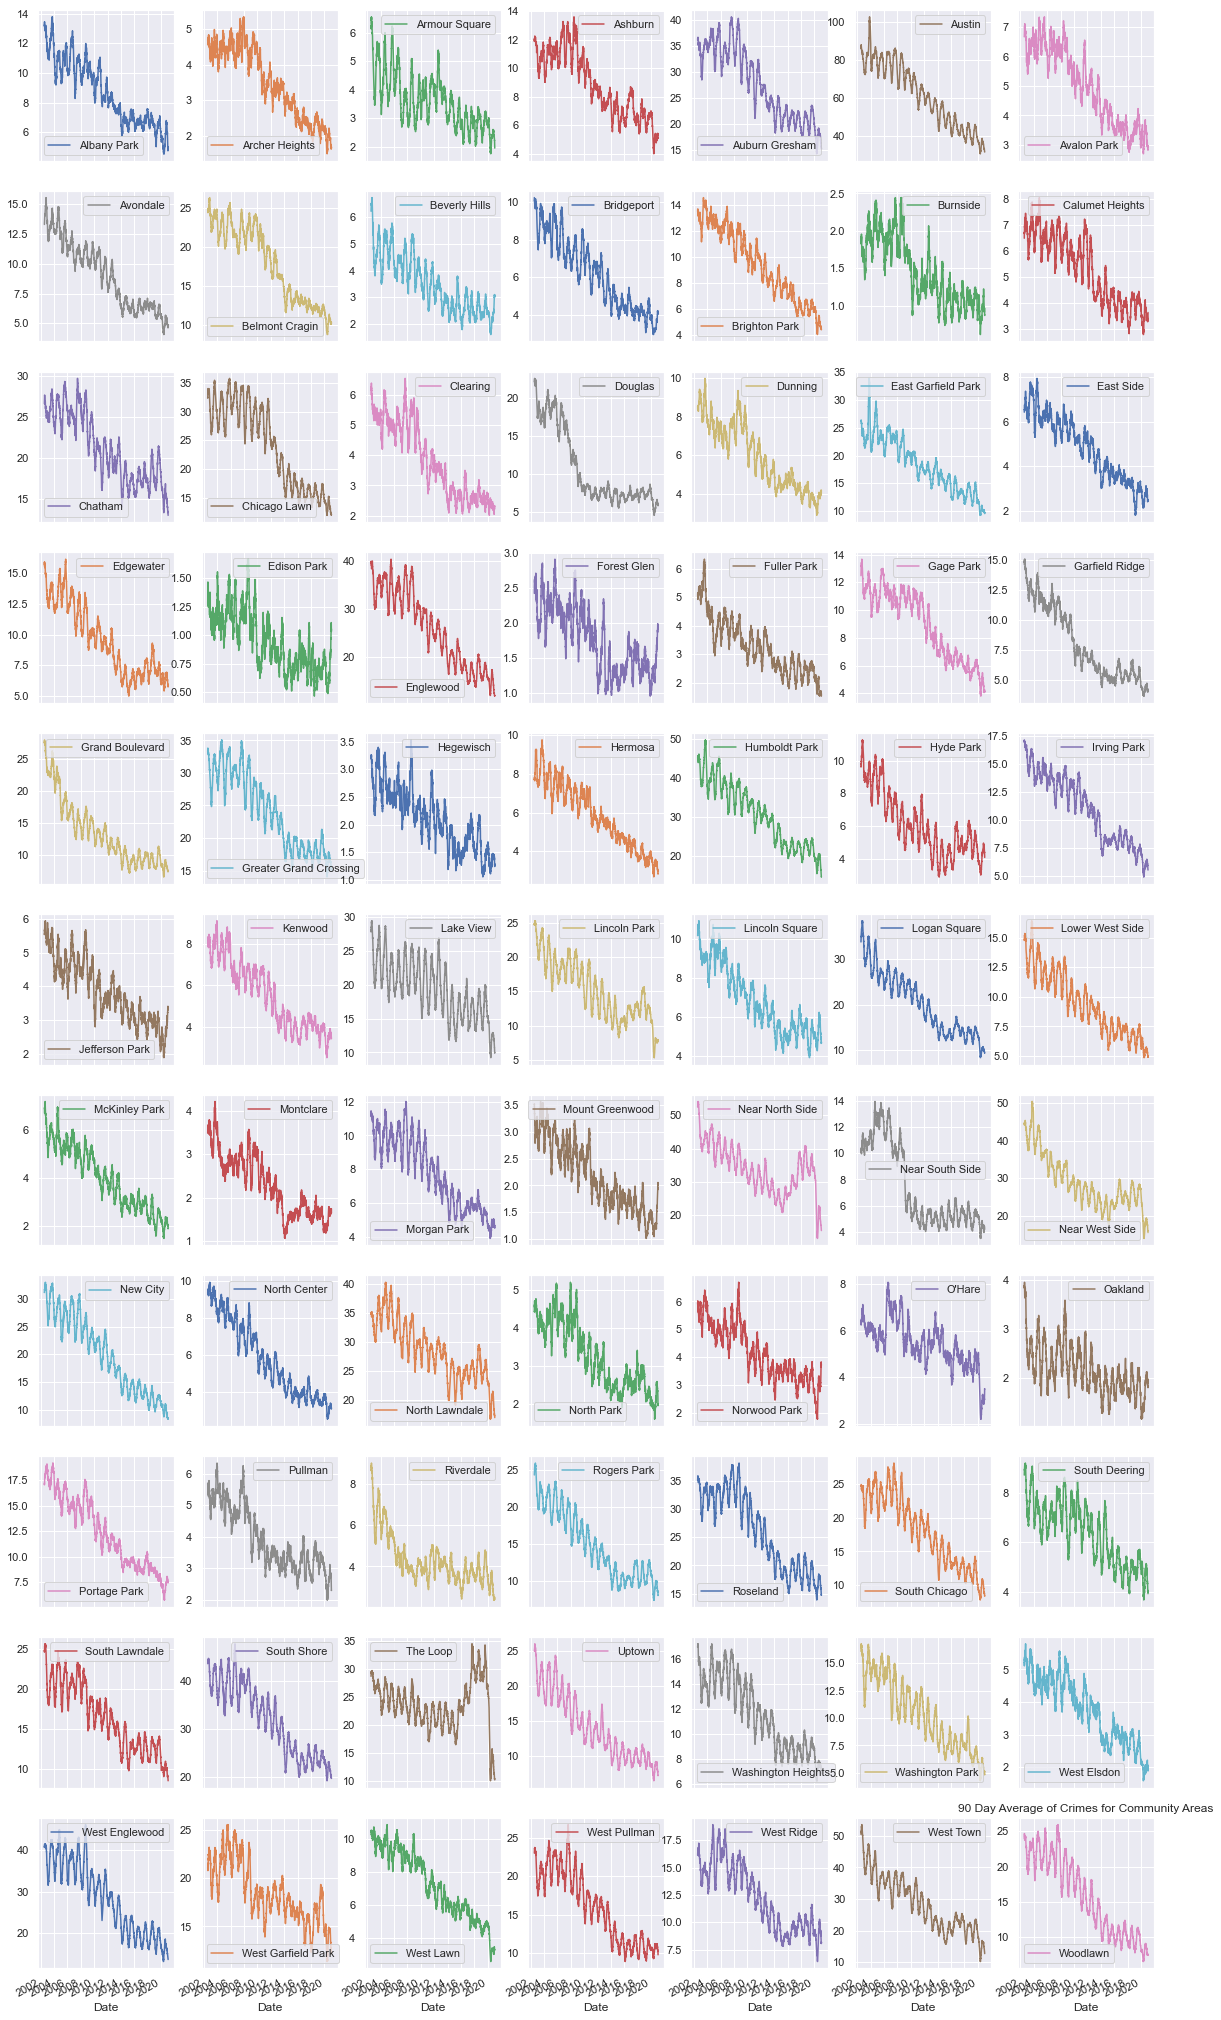

In [52]:
crimes_byarea_90DayAvg.plot(subplots=True, layout=(11,7), figsize=(20,40),legend=True)
plt.title('90 Day Average of Crimes for Community Areas');

I do seem to see a few different profiles here.  It will be interesting to see how clustering works on these timeseries.  